# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import precision_recall_fscore_support, average_precision_score, ndcg_score

# Loading the Data

In [2]:
df_rv = pd.read_csv('../datasets/reviews-cleaned.csv')

# Collaborative Recommenders

In [3]:
df_rv_rate = df_rv.set_index('user').copy()
df_rv_rate = df_rv_rate.groupby(['user', 'name']).mean()

all_users = list(df_rv_rate.index.get_level_values('user').unique())
df_users = df_rv_rate[df_rv_rate.index.get_level_values('user').isin(all_users)].copy()
df_users

rating
user            name                                  
1 Family Meeple 10 Days in Europe                  4.1
                12 Days                            7.0
                7 Wonders                          6.5
                A Column of Fire                   5.0
                A Feast for Odin                  10.0
...                                                ...
zuzusdad        Wreck Raiders                      9.2
                XCOM: The Board Game               8.4
                Xia: Legends of a Drift System     6.5
                Zombie Dice                        7.0
                Zooloretto                         9.9

[2018715 rows x 1 columns]

**User-based Collaborative Recommender**

In [4]:
# User-based pivot table
user_pivot = pd.pivot_table(df_rv, index='user', columns='name', values='rating')
user_pivot.head()

name,"...and then, we held hands.",...und tschüss!,10 Days in Africa,10 Days in Asia,10 Days in Europe,10 Days in the Americas,10 Days in the USA,10 Minute Heist: The Wizard's Tower,10' to Kill,1000 Blank White Cards,...,Zooloretto Junior,Zooloretto: The Dice Game,Zoowaboo,Zug um Zug: Deutschland,Zulus on the Ramparts!: The Battle of Rorke's Drift – Second Edition,ZÈRTZ,[redacted],duck! duck! Go!,ebbes,iKNOW
user,,,,,,,,,,,,,,,,,,,,,
1 Family Meeple,NaN,NaN,NaN,NaN,4.1,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,6.5,4.0,NaN,NaN
1000rpm,NaN,NaN,NaN,NaN,7.0,NaN,NaN,NaN,NaN,NaN,...,NaN,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28green,NaN,NaN,NaN,NaN,7.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42amu,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
549sd,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN


In [5]:
# Fill Null with avg
# user_pivot = user_pivot.apply(lambda row: row.fillna(row.mean()), axis=1)
user_pivot = user_pivot.fillna(0)
user_pivot.head()

name,"...and then, we held hands.",...und tschüss!,10 Days in Africa,10 Days in Asia,10 Days in Europe,10 Days in the Americas,10 Days in the USA,10 Minute Heist: The Wizard's Tower,10' to Kill,1000 Blank White Cards,...,Zooloretto Junior,Zooloretto: The Dice Game,Zoowaboo,Zug um Zug: Deutschland,Zulus on the Ramparts!: The Battle of Rorke's Drift – Second Edition,ZÈRTZ,[redacted],duck! duck! Go!,ebbes,iKNOW
user,,,,,,,,,,,,,,,,,,,,,
1 Family Meeple,0.0,0.0,0.0,0.0,4.1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6.5,4.0,0.0,0.0
1000rpm,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28green,0.0,0.0,0.0,0.0,7.0,0.0,7.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42amu,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
549sd,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0


In [6]:
# Sparse matrix
sparse_user_pivot = sparse.csr_matrix(user_pivot)

# Convert type to save memory
sparse_user_pivot = sparse_user_pivot.astype(np.float32)
sparse_user_pivot

<3067x4582 sparse matrix of type '<class 'numpy.float32'>'
	with 2018715 stored elements in Compressed Sparse Row format>

In [7]:
# Similarity matrix
user_similarities = cosine_similarity(sparse_user_pivot)
user_similarities

array([[1.0000013 , 0.35132778, 0.44122967, ..., 0.33333313, 0.32253665,
        0.40138492],
       [0.35132778, 1.000003  , 0.38480732, ..., 0.358057  , 0.28843167,
        0.3961942 ],
       [0.44122967, 0.38480732, 0.9999994 , ..., 0.32477707, 0.28985673,
        0.45373744],
       ...,
       [0.33333313, 0.358057  , 0.32477707, ..., 1.0000007 , 0.460744  ,
        0.306209  ],
       [0.32253665, 0.28843167, 0.28985673, ..., 0.460744  , 1.0000017 ,
        0.2733309 ],
       [0.40138492, 0.3961942 , 0.45373744, ..., 0.306209  , 0.2733309 ,
        1.0000002 ]], dtype=float32)

In [8]:
# Use it as a dataframe
user_cf_df = pd.DataFrame(user_similarities, index=user_pivot.index, columns=user_pivot.index)
user_cf_df.head()

user,1 Family Meeple,1000rpm,28green,42amu,549sd,AHforever,AJBrandon,ASSaali,Aarkas,AaronBE85,...,zhiwiller,zizishaoye,zodball,zottirgen,zpark999,zsknight,zumba,zumikon,zunnesteke,zuzusdad
user,,,,,,,,,,,,,,,,,,,,,
1 Family Meeple,1.000001,0.351328,0.441230,0.463583,0.431945,0.327051,0.307018,0.348769,0.365398,0.422336,...,0.413991,0.387728,0.435491,0.427697,0.428628,0.434545,0.264001,0.333333,0.322537,0.401385
1000rpm,0.351328,1.000003,0.384807,0.314870,0.343502,0.153420,0.327590,0.341947,0.277185,0.328638,...,0.287583,0.364414,0.254238,0.306647,0.342873,0.345588,0.347187,0.358057,0.288432,0.396194
28green,0.441230,0.384807,0.999999,0.414176,0.423904,0.287099,0.382935,0.345915,0.311133,0.390536,...,0.454744,0.414215,0.372633,0.391947,0.457808,0.396022,0.272193,0.324777,0.289857,0.453737
42amu,0.463583,0.314870,0.414176,0.999997,0.449813,0.357573,0.294944,0.381349,0.405254,0.469776,...,0.408089,0.397024,0.433965,0.445356,0.444515,0.464872,0.300592,0.386128,0.412055,0.370331
549sd,0.431945,0.343502,0.423904,0.449813,0.999995,0.348759,0.383475,0.390232,0.403238,0.501875,...,0.475182,0.473047,0.448085,0.474304,0.544098,0.479252,0.310789,0.365346,0.389563,0.378417


In [9]:
df_eval = pd.DataFrame()

for user in all_users:
  # dataframe of favourite games
  df_user = df_users.loc[user]
  avg = df_user['rating'].mean()
  df_fav = df_user[df_user['rating'] >= avg]  

  # most similar user
  user_sim = user_cf_df[user].drop(user).idxmax()

  # top 10 similar games
  user_rated_games = user_pivot.loc[user_sim]
  df_sim = user_rated_games.sort_values(ascending=False)[:10]
  
  # create lists to store the true and predicted labels
  true_labels = []
  pred_labels = []

  # create lists to store the true and predicted labels for ndcg
  y_true = []
  y_pred = []

  for game,sim in df_sim.iteritems():
    y_pred.append(sim)
    # if the recommendation is in the user's preferred games, it is a true positive
    if game in df_fav.index:
      true_labels.append(1)
      pred_labels.append(1)
      y_true.append(df_user.loc[game]['rating'])
      
    # if the recommendation is not in the user's preferred games, it is a false positive
    else:
      true_labels.append(0)
      pred_labels.append(1)
      y_true.append(0)

  # for each game in the user's preferred games, check if it was recommended
  for game,rate in df_fav.itertuples():
    if game not in df_sim:
      true_labels.append(1)
      pred_labels.append(0)
      y_pred.append(0)
      y_true.append(df_user.loc[game]['rating'])

  # calculate precision and recall
  precision, recall, _, _ = precision_recall_fscore_support(y_true=true_labels, y_pred=pred_labels, average='binary')
  ndcg = ndcg_score([y_true],[y_pred], k=10, ignore_ties=True)

  # dataframe evaluate
  df_eval[user] = {'precision': f'{precision:.2f}', 'recall': f'{recall:.4f}', 'ndcg': f'{ndcg:.4f}'}

df_eval = df_eval.T
print("Precision Average:",pd.to_numeric(df_eval['precision']).mean())
print("Recall Average:",pd.to_numeric(df_eval['recall']).mean())
print("NDCG:",pd.to_numeric(df_eval['ndcg']).mean())

Precision Average: 0.565927616563417
Recall Average: 0.018032637756765568
NDCG: 0.4927384740789045


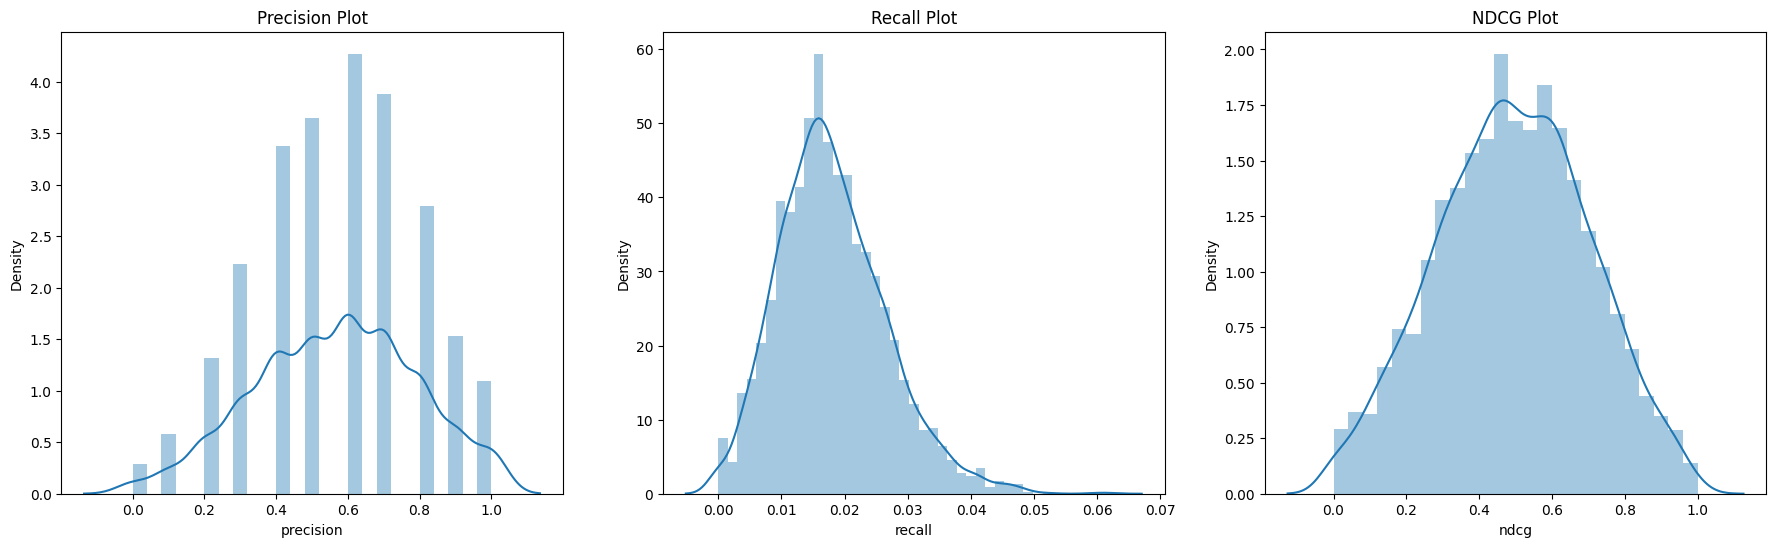

In [10]:
plt.figure(figsize=(22,6))

plt.subplot(1,3,1)
plt.title("Precision Plot")
sns.distplot(df_eval['precision'])

plt.subplot(1,3,2)
plt.title("Recall Plot")
sns.distplot(df_eval['recall'])

plt.subplot(1,3,3)
plt.title("NDCG Plot")
sns.distplot(df_eval['ndcg'])

plt.show()

**Item-based Collaborative Recommender**

In [11]:
# User-based pivot table
item_pivot = pd.pivot_table(df_rv, index='name', columns='user', values='rating')
item_pivot.head()

user,1 Family Meeple,1000rpm,28green,42amu,549sd,AHforever,AJBrandon,ASSaali,Aarkas,AaronBE85,...,zhiwiller,zizishaoye,zodball,zottirgen,zpark999,zsknight,zumba,zumikon,zunnesteke,zuzusdad
name,,,,,,,,,,,,,,,,,,,,,
"...and then, we held hands.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...und tschüss!,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,NaN,NaN
10 Days in Africa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.3,NaN,NaN,NaN,NaN,4.0,6.5,NaN,NaN
10 Days in Asia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10 Days in Europe,4.1,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,7.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
item_pivot = item_pivot.fillna(0)
item_pivot.head()

user,1 Family Meeple,1000rpm,28green,42amu,549sd,AHforever,AJBrandon,ASSaali,Aarkas,AaronBE85,...,zhiwiller,zizishaoye,zodball,zottirgen,zpark999,zsknight,zumba,zumikon,zunnesteke,zuzusdad
name,,,,,,,,,,,,,,,,,,,,,
"...and then, we held hands.",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...und tschüss!,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,0.0
10 Days in Africa,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.3,0.0,0.0,0.0,0.0,4.0,6.5,0.0,0.0
10 Days in Asia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10 Days in Europe,4.1,7.0,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Sparse matrix
sparse_item_pivot = sparse.csr_matrix(item_pivot)


# Similarity matrix
item_similarities = cosine_similarity(sparse_item_pivot)

# Use it as a dataframe
item_cf_df = pd.DataFrame(item_similarities, index=item_pivot.index, columns=item_pivot.index)
item_cf_df.head()

name,"...and then, we held hands.",...und tschüss!,10 Days in Africa,10 Days in Asia,10 Days in Europe,10 Days in the Americas,10 Days in the USA,10 Minute Heist: The Wizard's Tower,10' to Kill,1000 Blank White Cards,...,Zooloretto Junior,Zooloretto: The Dice Game,Zoowaboo,Zug um Zug: Deutschland,Zulus on the Ramparts!: The Battle of Rorke's Drift – Second Edition,ZÈRTZ,[redacted],duck! duck! Go!,ebbes,iKNOW
name,,,,,,,,,,,,,,,,,,,,,
"...and then, we held hands.",1.000000,0.080115,0.158781,0.108188,0.140938,0.108727,0.127127,0.147714,0.141141,0.061741,...,0.075312,0.187834,0.076062,0.086458,0.098297,0.185706,0.165226,0.095863,0.127687,0.080030
...und tschüss!,0.080115,1.000000,0.164283,0.135121,0.228677,0.106158,0.131682,0.073456,0.054965,0.035974,...,0.121544,0.175149,0.139251,0.096781,0.034480,0.172880,0.065776,0.166939,0.199616,0.059040
10 Days in Africa,0.158781,0.164283,1.000000,0.584768,0.551947,0.481432,0.553647,0.096274,0.070299,0.134278,...,0.175300,0.268873,0.173794,0.063029,0.116536,0.336803,0.089493,0.284904,0.098230,0.087955
10 Days in Asia,0.108188,0.135121,0.584768,1.000000,0.541234,0.591203,0.509913,0.078295,0.052857,0.098025,...,0.157740,0.237408,0.146475,0.068021,0.094460,0.272813,0.054192,0.252753,0.079539,0.076176
10 Days in Europe,0.140938,0.228677,0.551947,0.541234,1.000000,0.474869,0.520611,0.148301,0.101523,0.097216,...,0.169539,0.290477,0.212485,0.097823,0.074929,0.338660,0.089756,0.235569,0.140514,0.147720


In [14]:
# Top 10 similar board games
item_input = 'Wingspan'
item_sim = item_cf_df[item_input]
item_sim.index = item_cf_df.index.astype(str)
item_sim = item_sim[item_sim > 0].drop(item_input)
item_sim.sort_values(ascending=False).head(10)

name
Azul                       0.889526
7 Wonders                  0.878789
Terraforming Mars          0.877635
Splendor                   0.872865
Codenames                  0.870020
The Castles of Burgundy    0.866457
Pandemic                   0.865538
7 Wonders Duel             0.864552
Five Tribes                0.856681
Dominion                   0.855331
Name: Wingspan, dtype: float64

In [15]:
df_eval = pd.DataFrame()

for user in all_users:
  # dataframe of favourite games
  df_user = df_users.loc[user]
  avg = df_user['rating'].mean()
  df_fav = df_user[df_user['rating'] >= avg]  

  # most favourite game
  game_fav = df_fav['rating'].idxmax()

  # top 10 similar games
  df_sim = item_cf_df[game_fav].sort_values(ascending=False)[:10]

  # create lists to store the true and predicted labels
  true_labels = []
  pred_labels = []

  # create lists to store the true and predicted labels for ndcg
  y_true = []
  y_pred = []

  for game,sim in df_sim.iteritems():
    y_pred.append(sim)
    # if the recommendation is in the user's preferred games, it is a true positive
    if game in df_fav.index:
      true_labels.append(1)
      pred_labels.append(1)
      y_true.append(df_user.loc[game]['rating'])
      
    # if the recommendation is not in the user's preferred games, it is a false positive
    else:
      true_labels.append(0)
      pred_labels.append(1)
      y_true.append(0)

  # for each game in the user's preferred games, check if it was recommended
  for game,rate in df_fav.itertuples():
    if game not in df_sim:
      true_labels.append(1)
      pred_labels.append(0)
      y_pred.append(0)
      y_true.append(df_user.loc[game]['rating'])

  # calculate precision and recall
  precision, recall, _, _ = precision_recall_fscore_support(y_true=true_labels, y_pred=pred_labels, average='binary')
  ndcg = ndcg_score([y_true],[y_pred], k=10, ignore_ties=True)

  # dataframe evaluate
  df_eval[user] = {'precision': f'{precision:.2f}', 'recall': f'{recall:.4f}', 'ndcg': f'{ndcg:.4f}'}

df_eval = df_eval.T
print("Precision Average:",pd.to_numeric(df_eval['precision']).mean())
print("Recall Average:",pd.to_numeric(df_eval['recall']).mean())
print("NDCG:",pd.to_numeric(df_eval['ndcg']).mean())

Precision Average: 0.7079230518421912
Recall Average: 0.022769775024453865
NDCG: 0.6801655689598956


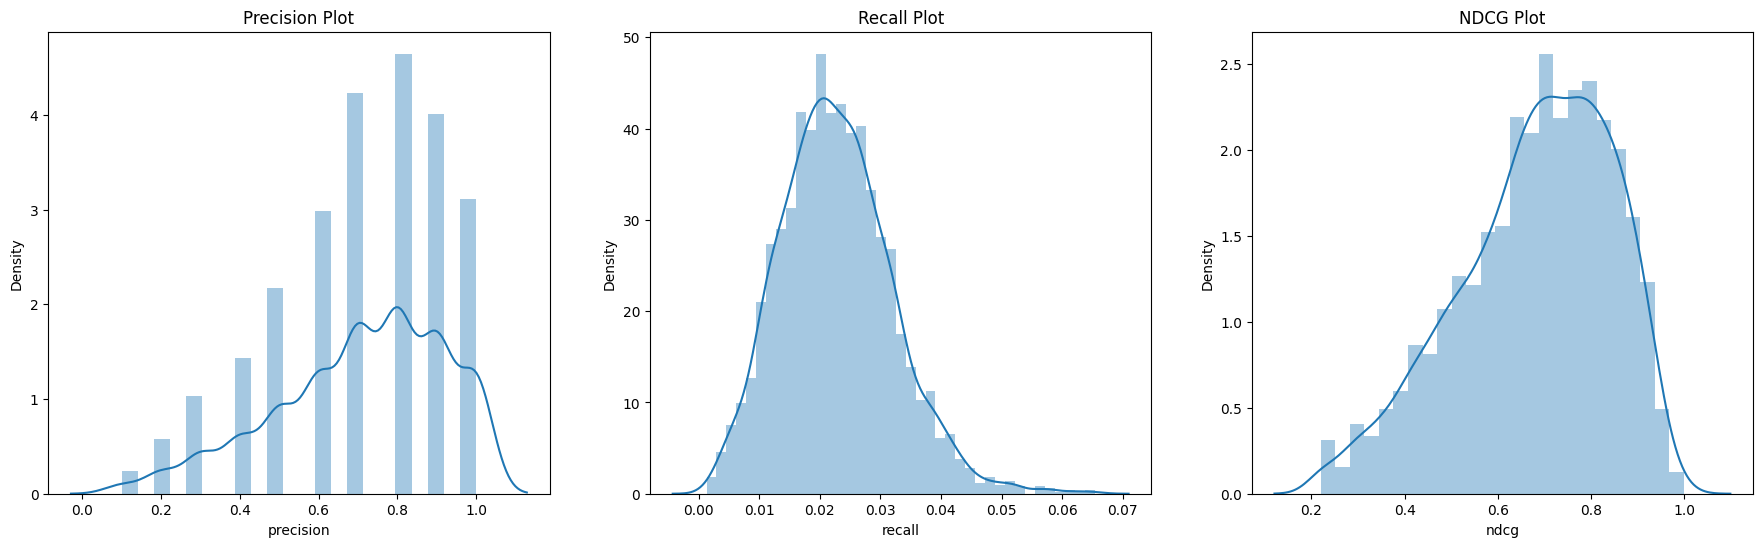

In [16]:
plt.figure(figsize=(22,6))

plt.subplot(1,3,1)
plt.title("Precision Plot")
sns.distplot(df_eval['precision'])

plt.subplot(1,3,2)
plt.title("Recall Plot")
sns.distplot(df_eval['recall'])

plt.subplot(1,3,3)
plt.title("NDCG Plot")
sns.distplot(df_eval['ndcg'])

plt.show()

**Combine User-based & Item-based**

In [17]:
df_eval = pd.DataFrame()

for user in all_users:
  # dataframe of favourite games
  df_user = df_users.loc[user]
  avg = df_user['rating'].mean()
  df_fav = df_user[df_user['rating'] >= avg]  

  # most similar user
  user_sim = user_cf_df[user].drop(user).idxmax()

  # most favourite game by similar user
  user_sim_fav_game = df_users.loc[user_sim]['rating'].idxmax()

  # top 10 similar games
  df_sim = item_cf_df[user_sim_fav_game].sort_values(ascending=False)[:10]
  
  # create lists to store the true and predicted labels
  true_labels = []
  pred_labels = []

  # create lists to store the true and predicted labels for ndcg
  y_true = []
  y_pred = []

  for game,sim in df_sim.iteritems():
    y_pred.append(sim)
    # if the recommendation is in the user's preferred games, it is a true positive
    if game in df_fav.index:
      true_labels.append(1)
      pred_labels.append(1)
      y_true.append(df_user.loc[game]['rating'])
      
    # if the recommendation is not in the user's preferred games, it is a false positive
    else:
      true_labels.append(0)
      pred_labels.append(1)
      y_true.append(0)

  # for each game in the user's preferred games, check if it was recommended
  for game,rate in df_fav.itertuples():
    if game not in df_sim:
      true_labels.append(1)
      pred_labels.append(0)
      y_pred.append(0)
      y_true.append(df_user.loc[game]['rating'])

  # calculate precision and recall
  precision, recall, _, _ = precision_recall_fscore_support(y_true=true_labels, y_pred=pred_labels, average='binary')
  ndcg = ndcg_score([y_true],[y_pred], k=10, ignore_ties=True)

  # dataframe evaluate
  df_eval[user] = {'precision': f'{precision:.2f}', 'recall': f'{recall:.4f}', 'ndcg': f'{ndcg:.4f}'}

df_eval = df_eval.T
print("Precision Average:",pd.to_numeric(df_eval['precision']).mean())
print("Recall Average:",pd.to_numeric(df_eval['recall']).mean())
print("NDCG:",pd.to_numeric(df_eval['ndcg']).mean())

Precision Average: 0.6121617215520052
Recall Average: 0.019592370394522333
NDCG: 0.518602543201826


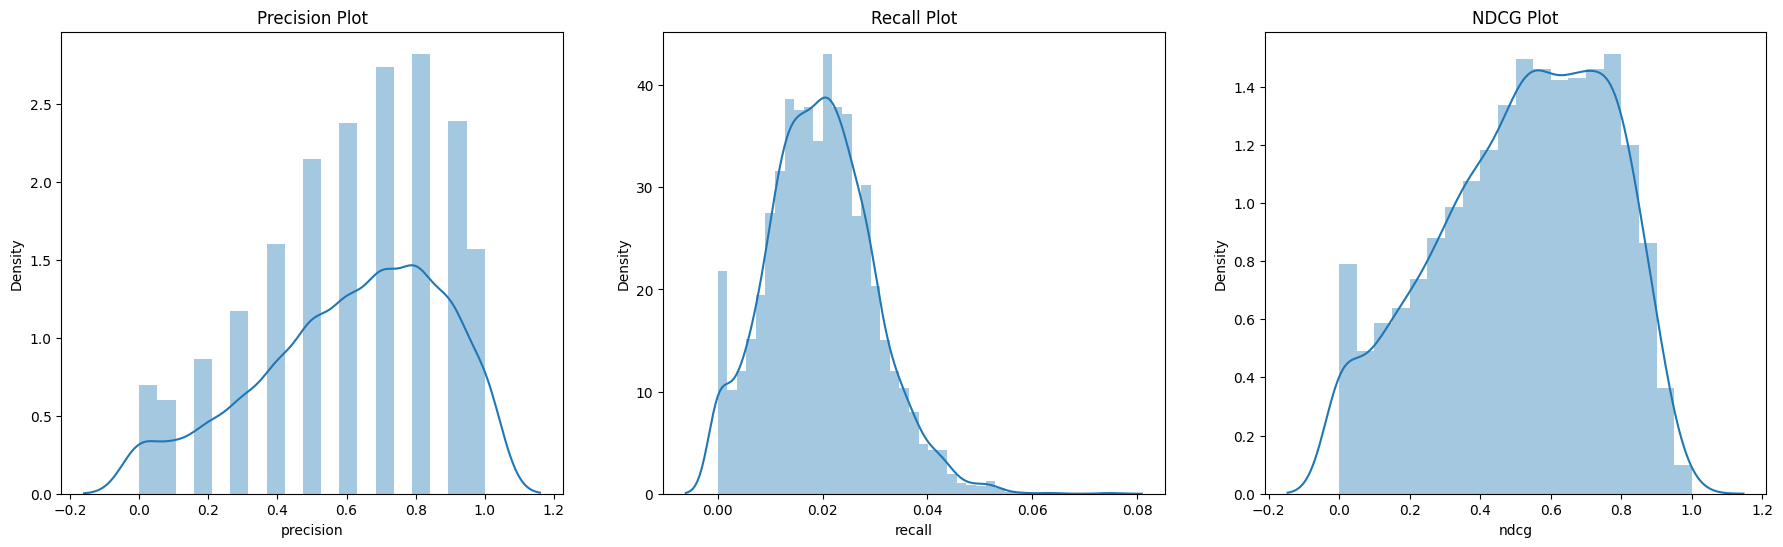

In [18]:
plt.figure(figsize=(22,6))

plt.subplot(1,3,1)
plt.title("Precision Plot")
sns.distplot(df_eval['precision'])

plt.subplot(1,3,2)
plt.title("Recall Plot")
sns.distplot(df_eval['recall'])

plt.subplot(1,3,3)
plt.title("NDCG Plot")
sns.distplot(df_eval['ndcg'])

plt.show()

ผลลัพธ์ของ **Item-Based Collaborative Filtering** ดีที่สุด

# Save Item-Based to CSV

In [19]:
# item_cf_df.to_csv('item-based.csv', index=True)